# DECEPTIVE REVIEW CLASSIFIER

In [1]:
!pip uninstall torch torchvision -y
!pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!pip install -U transformers
!pip install -U simpletransformers  

Found existing installation: torch 1.9.0+cu102
Uninstalling torch-1.9.0+cu102:
  Successfully uninstalled torch-1.9.0+cu102
Found existing installation: torchvision 0.10.0+cu102
Uninstalling torchvision-0.10.0+cu102:
  Successfully uninstalled torchvision-0.10.0+cu102
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 708.0 MB 10 kB/s 
     |████████████████████████████████| 5.9 MB 381 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.10.0 requires torch==1.9.0, but you have torch 1.6.0+cu101 which is incompatible.
     |████████████████████████████████| 2.8 MB 12.4 MB/s 
     |████████████████████████████████| 52 kB 1.5 MB/s 
     |████████████████████████████████| 636 kB 48.8 MB/s 
     |████████████████████████████████| 3.3 MB 25.3 MB/s 
     |████████████████████████████████| 895 kB 4

In [2]:
# installing transformers
!pip install --upgrade transformers
!pip install simpletransformers
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=6ca218b0c6286f760ebd74ffdcb7d2994e47d383b4b33aac6aff13807b64e076
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built gputil


In [3]:
# using GPU
import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " |     Proc size: " + humanize.naturalsize(process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 12.8 GB  |     Proc size: 158.1 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total     11441MB


In [4]:
# importing libraries
from tqdm import tqdm
import warnings
warnings.simplefilter('ignore')
import gc
from scipy.special import softmax
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from simpletransformers.classification import ClassificationModel
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold

In [5]:
!pip install nlpaug

     |████████████████████████████████| 405 kB 13.2 MB/s 


In [6]:
#importing libraries
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import statistics
import math
import os
import re
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix
from nltk.corpus import stopwords
import string
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
import re
pd.set_option('max_colwidth', 800)

import warnings
warnings.filterwarnings("ignore")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [7]:
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer

import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc

from nlpaug.util import Action

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from tensorflow.keras.initializers import Constant
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

In [9]:
#loading dataset
df=pd.read_csv('/content/deceptive.csv')
df.head()

,deceptive,hotel,polarity,source,text
0,truthful,conrad,positive,TripAdvisor,"We stayed for a one night getaway with family on a thursday. Triple AAA rate of 173 was a steal. 7th floor room complete with 44in plasma TV bose stereo, voss and evian water, and gorgeous bathroom(no tub but was fine for us) Concierge was very helpful. You cannot beat this location... Only flaw was breakfast was pricey and service was very very slow(2hours for four kids and four adults on a friday morning) even though there were only two other tables in the restaurant. Food was very good so it was worth the wait. I would return in a heartbeat. A gem in chicago... \n"
1,truthful,hyatt,positive,TripAdvisor,"Triple A rate with upgrade to view room was less than $200 which also included breakfast vouchers. Had a great view of river, lake, Wrigley Bldg. & Tribune Bldg. Most major restaurants, Shopping, Sightseeing attractions within walking distance. Large room with a very comfortable bed. \n"
2,truthful,hyatt,positive,TripAdvisor,"This comes a little late as I'm finally catching up on my reviews from the past several months:) A dear friend and I stayed at the Hyatt Regency in late October 2007 for one night while visiting a friend and her husband from out of town. This hotel is perfect, IMO. Easy check in and check out. Lovely, clean, comfortable rooms with great views of the city. I know this area pretty well and it's very convenient to many downtown Chicago attractions. We had dinner and went clubing with our friends around Division St.. We had no problems getting cabs back and forth to the Hyatt and there's even public transportation right near by but we didn't bother since we only needed cabs from and to the hotel. Parking, as is usual for Chicago, was expensive but we were able to get our car out quickly (h..."
3,truthful,omni,positive,TripAdvisor,"The Omni Chicago really delivers on all fronts, from the spaciousness of the rooms to the helpful staff to the prized location on Michigan Avenue. While this address in Chicago requires a high level of quality, the Omni delivers. Check in for myself and a whole group of people with me was under 3 minutes, the staff had plentiful recommendations for dining and events, and the rooms are some of the largest you'll find at this price range in Chicago. Even the 'standard' room has a separate living area and work desk. The fitness center has free weights, weight machines, and two rows of cardio equipment. I shared the room with 7 others and did not feel cramped in any way! All in all, a great property! \n"
4,truthful,hyatt,positive,TripAdvisor,"I asked for a high floor away from the elevator and that is what I got. The room was pleasantly decorated, functional and very clean. I didn't need a whole lot of service but when I did they were pleasant and prompt. I used the fitness center which was well equipped and everything was in working order. It is in a great location at one end of the Michigan Avenue shopping district. \n"


In [10]:
df.shape

(1600, 5)

In [11]:
df['deceptive'].value_counts()

truthful     800
deceptive    800
Name: deceptive, dtype: int64

In [12]:
df['polarity'].value_counts()

negative    800
positive    800
Name: polarity, dtype: int64

This is perfectly balanced dataset. Our target variable is 'deceptive'.

In [13]:
df['hotel'].value_counts()

hilton              80
intercontinental    80
fairmont            80
swissotel           80
ambassador          80
hyatt               80
conrad              80
sheraton            80
allegro             80
talbott             80
james               80
omni                80
amalfi              80
sofitel             80
knickerbocker       80
affinia             80
homewood            80
hardrock            80
monaco              80
palmer              80
Name: hotel, dtype: int64

In [14]:
df['source'].value_counts()

MTurk          800
Web            400
TripAdvisor    400
Name: source, dtype: int64

### DATA PREPROCESSING AND EDA

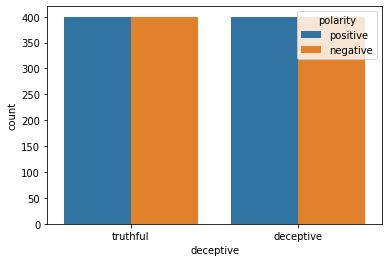

In [15]:
import seaborn as sns
sns.countplot(x=df['deceptive'],hue='polarity',data=df)

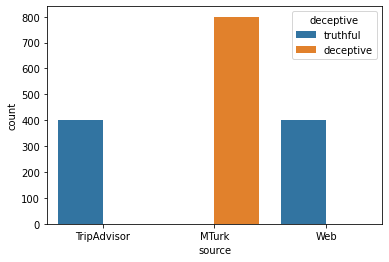

In [16]:
sns.countplot(x=df['source'],hue='deceptive',data=df)

In [17]:
df.columns

Index(['deceptive', 'hotel', 'polarity', 'source', 'text'], dtype='object')

In [18]:
# so combining three text columns --- hotel, source, text
#df['text'] = df['hotel']+' '+df['source']+' '+df['text']
#df.head()

In [19]:
# dropping unnecessary columns. 
# dropping hotel names
# dropping the source of the data
# dropping the polarity of the dataset
df.drop(['hotel', 'polarity', 'source'], axis = 1, inplace=True)
df.head()

,deceptive,text
0,truthful,"We stayed for a one night getaway with family on a thursday. Triple AAA rate of 173 was a steal. 7th floor room complete with 44in plasma TV bose stereo, voss and evian water, and gorgeous bathroom(no tub but was fine for us) Concierge was very helpful. You cannot beat this location... Only flaw was breakfast was pricey and service was very very slow(2hours for four kids and four adults on a friday morning) even though there were only two other tables in the restaurant. Food was very good so it was worth the wait. I would return in a heartbeat. A gem in chicago... \n"
1,truthful,"Triple A rate with upgrade to view room was less than $200 which also included breakfast vouchers. Had a great view of river, lake, Wrigley Bldg. & Tribune Bldg. Most major restaurants, Shopping, Sightseeing attractions within walking distance. Large room with a very comfortable bed. \n"
2,truthful,"This comes a little late as I'm finally catching up on my reviews from the past several months:) A dear friend and I stayed at the Hyatt Regency in late October 2007 for one night while visiting a friend and her husband from out of town. This hotel is perfect, IMO. Easy check in and check out. Lovely, clean, comfortable rooms with great views of the city. I know this area pretty well and it's very convenient to many downtown Chicago attractions. We had dinner and went clubing with our friends around Division St.. We had no problems getting cabs back and forth to the Hyatt and there's even public transportation right near by but we didn't bother since we only needed cabs from and to the hotel. Parking, as is usual for Chicago, was expensive but we were able to get our car out quickly (h..."
3,truthful,"The Omni Chicago really delivers on all fronts, from the spaciousness of the rooms to the helpful staff to the prized location on Michigan Avenue. While this address in Chicago requires a high level of quality, the Omni delivers. Check in for myself and a whole group of people with me was under 3 minutes, the staff had plentiful recommendations for dining and events, and the rooms are some of the largest you'll find at this price range in Chicago. Even the 'standard' room has a separate living area and work desk. The fitness center has free weights, weight machines, and two rows of cardio equipment. I shared the room with 7 others and did not feel cramped in any way! All in all, a great property! \n"
4,truthful,"I asked for a high floor away from the elevator and that is what I got. The room was pleasantly decorated, functional and very clean. I didn't need a whole lot of service but when I did they were pleasant and prompt. I used the fitness center which was well equipped and everything was in working order. It is in a great location at one end of the Michigan Avenue shopping district. \n"


In [20]:
z = {'truthful' : 1, 'deceptive' : 0}  # 1 for truthful reviews and 0 for deceptive reviews
df['deceptive'] = df['deceptive'].map(z)

In [21]:
df.head()

,deceptive,text
0,1,"We stayed for a one night getaway with family on a thursday. Triple AAA rate of 173 was a steal. 7th floor room complete with 44in plasma TV bose stereo, voss and evian water, and gorgeous bathroom(no tub but was fine for us) Concierge was very helpful. You cannot beat this location... Only flaw was breakfast was pricey and service was very very slow(2hours for four kids and four adults on a friday morning) even though there were only two other tables in the restaurant. Food was very good so it was worth the wait. I would return in a heartbeat. A gem in chicago... \n"
1,1,"Triple A rate with upgrade to view room was less than $200 which also included breakfast vouchers. Had a great view of river, lake, Wrigley Bldg. & Tribune Bldg. Most major restaurants, Shopping, Sightseeing attractions within walking distance. Large room with a very comfortable bed. \n"
2,1,"This comes a little late as I'm finally catching up on my reviews from the past several months:) A dear friend and I stayed at the Hyatt Regency in late October 2007 for one night while visiting a friend and her husband from out of town. This hotel is perfect, IMO. Easy check in and check out. Lovely, clean, comfortable rooms with great views of the city. I know this area pretty well and it's very convenient to many downtown Chicago attractions. We had dinner and went clubing with our friends around Division St.. We had no problems getting cabs back and forth to the Hyatt and there's even public transportation right near by but we didn't bother since we only needed cabs from and to the hotel. Parking, as is usual for Chicago, was expensive but we were able to get our car out quickly (h..."
3,1,"The Omni Chicago really delivers on all fronts, from the spaciousness of the rooms to the helpful staff to the prized location on Michigan Avenue. While this address in Chicago requires a high level of quality, the Omni delivers. Check in for myself and a whole group of people with me was under 3 minutes, the staff had plentiful recommendations for dining and events, and the rooms are some of the largest you'll find at this price range in Chicago. Even the 'standard' room has a separate living area and work desk. The fitness center has free weights, weight machines, and two rows of cardio equipment. I shared the room with 7 others and did not feel cramped in any way! All in all, a great property! \n"
4,1,"I asked for a high floor away from the elevator and that is what I got. The room was pleasantly decorated, functional and very clean. I didn't need a whole lot of service but when I did they were pleasant and prompt. I used the fitness center which was well equipped and everything was in working order. It is in a great location at one end of the Michigan Avenue shopping district. \n"


In [22]:
df['text'][1]

'Triple A rate with upgrade to view room was less than $200 which also included breakfast vouchers. Had a great view of river, lake, Wrigley Bldg. & Tribune Bldg. Most major restaurants, Shopping, Sightseeing attractions within walking distance. Large room with a very comfortable bed. \n'

In [23]:
# Cleaning Raw tweets
def clean_text(text):
    
    #remove emails
    text = ' '.join([i for i in text.split() if '@' not in i])
    
    #remove web address
    text = re.sub('http[s]?://\S+', '', text)

    #remove brackets and parantheses (and removing the text inside the brackets and parantheses)
    text = re.sub("[\(\[].*?[\)\]]", "", text)

    #remove punctuations
    text = re.sub(r'[^\w\s]', ' ', text)
    
    #Filter to allow only alphabets and numbers
    text = re.sub(r'[^a-zA-Z\']', ' ', text)
    
    #Remove Unicode characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)

    #remove double spaces 
    text = re.sub('\s+', ' ', text)
    
    return text

In [24]:
# applying that into function.
df["clean_text"] = df['text'].apply(lambda x: clean_text(x))
df.head(10)

,deceptive,text,clean_text
0,1,"We stayed for a one night getaway with family on a thursday. Triple AAA rate of 173 was a steal. 7th floor room complete with 44in plasma TV bose stereo, voss and evian water, and gorgeous bathroom(no tub but was fine for us) Concierge was very helpful. You cannot beat this location... Only flaw was breakfast was pricey and service was very very slow(2hours for four kids and four adults on a friday morning) even though there were only two other tables in the restaurant. Food was very good so it was worth the wait. I would return in a heartbeat. A gem in chicago... \n",We stayed for a one night getaway with family on a thursday Triple AAA rate of was a steal th floor room complete with in plasma TV bose stereo voss and evian water and gorgeous bathroom Concierge was very helpful You cannot beat this location Only flaw was breakfast was pricey and service was very very slow even though there were only two other tables in the restaurant Food was very good so it was worth the wait I would return in a heartbeat A gem in chicago
1,1,"Triple A rate with upgrade to view room was less than $200 which also included breakfast vouchers. Had a great view of river, lake, Wrigley Bldg. & Tribune Bldg. Most major restaurants, Shopping, Sightseeing attractions within walking distance. Large room with a very comfortable bed. \n",Triple A rate with upgrade to view room was less than which also included breakfast vouchers Had a great view of river lake Wrigley Bldg Tribune Bldg Most major restaurants Shopping Sightseeing attractions within walking distance Large room with a very comfortable bed
2,1,"This comes a little late as I'm finally catching up on my reviews from the past several months:) A dear friend and I stayed at the Hyatt Regency in late October 2007 for one night while visiting a friend and her husband from out of town. This hotel is perfect, IMO. Easy check in and check out. Lovely, clean, comfortable rooms with great views of the city. I know this area pretty well and it's very convenient to many downtown Chicago attractions. We had dinner and went clubing with our friends around Division St.. We had no problems getting cabs back and forth to the Hyatt and there's even public transportation right near by but we didn't bother since we only needed cabs from and to the hotel. Parking, as is usual for Chicago, was expensive but we were able to get our car out quickly (h...",This comes a little late as I m finally catching up on my reviews from the past several months A dear friend and I stayed at the Hyatt Regency in late October for one night while visiting a friend and her husband from out of town This hotel is perfect IMO Easy check in and check out Lovely clean comfortable rooms with great views of the city I know this area pretty well and it s very convenient to many downtown Chicago attractions We had dinner and went clubing with our friends around Division St We had no problems getting cabs back and forth to the Hyatt and there s even public transportation right near by but we didn t bother since we only needed cabs from and to the hotel Parking as is usual for Chicago was expensive but we were able to get our car out quickly No problems at all and...
3,1,"The Omni Chicago really delivers on all fronts, from the spaciousness of the rooms to the helpful staff to the prized location on Michigan Avenue. While this address in Chicago requires a high level of quality, the Omni delivers. Check in for myself and a whole group of people with me was under 3 minutes, the staff had plentiful recommendations for dining and events, and the rooms are some of the largest you'll find at this price range in Chicago. Even the 'standard' room has a separate living area and work desk. The fitness center has free weights, weight machines, and two rows of cardio equipment. I shared the room with 7 others and did not feel cramped in any way! All in all, a great property! \n",The Omni Chicago really delivers on all front

In [25]:
# dropping the uncleaned text column "text"
df = df.drop(['text'], axis=1)

In [26]:
# renaming the column
df.rename(columns = {'clean_text':'text', 'deceptive' : 'label'}, inplace = True)
df.head()

,label,text
0,1,We stayed for a one night getaway with family on a thursday Triple AAA rate of was a steal th floor room complete with in plasma TV bose stereo voss and evian water and gorgeous bathroom Concierge was very helpful You cannot beat this location Only flaw was breakfast was pricey and service was very very slow even though there were only two other tables in the restaurant Food was very good so it was worth the wait I would return in a heartbeat A gem in chicago
1,1,Triple A rate with upgrade to view room was less than which also included breakfast vouchers Had a great view of river lake Wrigley Bldg Tribune Bldg Most major restaurants Shopping Sightseeing attractions within walking distance Large room with a very comfortable bed
2,1,This comes a little late as I m finally catching up on my reviews from the past several months A dear friend and I stayed at the Hyatt Regency in late October for one night while visiting a friend and her husband from out of town This hotel is perfect IMO Easy check in and check out Lovely clean comfortable rooms with great views of the city I know this area pretty well and it s very convenient to many downtown Chicago attractions We had dinner and went clubing with our friends around Division St We had no problems getting cabs back and forth to the Hyatt and there s even public transportation right near by but we didn t bother since we only needed cabs from and to the hotel Parking as is usual for Chicago was expensive but we were able to get our car out quickly No problems at all and...
3,1,The Omni Chicago really delivers on all fronts from the spaciousness of the rooms to the helpful staff to the prized location on Michigan Avenue While this address in Chicago requires a high level of quality the Omni delivers Check in for myself and a whole group of people with me was under minutes the staff had plentiful recommendations for dining and events and the rooms are some of the largest you ll find at this price range in Chicago Even the standard room has a separate living area and work desk The fitness center has free weights weight machines and two rows of cardio equipment I shared the room with others and did not feel cramped in any way All in all a great property
4,1,I asked for a high floor away from the elevator and that is what I got The room was pleasantly decorated functional and very clean I didn t need a whole lot of service but when I did they were pleasant and prompt I used the fitness center which was well equipped and everything was in working order It is in a great location at one end of the Michigan Avenue shopping district


In [27]:
# preprocessing the data (removing stopwords, convert the sentence to lower case, and also applying lemmatization to get meaningful words )
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
wnl=WordNetLemmatizer()
def clean_text(review):
  review = review.lower()
  review = review.split()
  review = [wnl.lemmatize(word) for word in review if word not in set(stopwords.words('english'))]
  review = ' '.join(review)
  return review

In [28]:
df['text']=df['text'].apply(clean_text)
df.head()

,label,text
0,1,stayed one night getaway family thursday triple aaa rate steal th floor room complete plasma tv bose stereo voss evian water gorgeous bathroom concierge helpful cannot beat location flaw breakfast pricey service slow even though two table restaurant food good worth wait would return heartbeat gem chicago
1,1,triple rate upgrade view room le also included breakfast voucher great view river lake wrigley bldg tribune bldg major restaurant shopping sightseeing attraction within walking distance large room comfortable bed
2,1,come little late finally catching review past several month dear friend stayed hyatt regency late october one night visiting friend husband town hotel perfect imo easy check check lovely clean comfortable room great view city know area pretty well convenient many downtown chicago attraction dinner went clubing friend around division st problem getting cab back forth hyatt even public transportation right near bother since needed cab hotel parking usual chicago expensive able get car quickly problem best part got rate hotwire downright steal area chicago quality hotel
3,1,omni chicago really delivers front spaciousness room helpful staff prized location michigan avenue address chicago requires high level quality omni delivers check whole group people minute staff plentiful recommendation dining event room largest find price range chicago even standard room separate living area work desk fitness center free weight weight machine two row cardio equipment shared room others feel cramped way great property
4,1,asked high floor away elevator got room pleasantly decorated functional clean need whole lot service pleasant prompt used fitness center well equipped everything working order great location one end michigan avenue shopping district


### WORD VISUALIZATION

In [29]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [30]:
#making worldcloud
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
stop_words=set(stopwords.words("english"))
print(stop_words)

{'the', 'am', "hadn't", "won't", 'it', 'theirs', 'before', 'all', 'down', 'ma', "mustn't", 'not', 'his', 'themselves', "she's", 'won', 'and', 'for', 'in', 'its', 'too', "shouldn't", "you're", 'nor', 'i', 'an', 'until', 'doesn', "haven't", 'on', 'haven', 'own', 'will', 'our', "mightn't", "isn't", 'this', 'with', 'where', 'needn', "don't", 'didn', "you'll", 'had', 'other', 'don', 'if', 'being', 'having', "you've", 'yourselves', 'why', 'during', 'what', 'from', 'them', 'ain', 'very', 'she', 'my', 'below', 'further', 'aren', 're', 'hasn', 'me', 'to', 'at', 'that', 'while', 'herself', 'he', 'shan', 'these', 'into', 'of', 'weren', 'have', 'hadn', 's', 'been', 'which', 'both', 'you', 'o', "that'll", 'between', 'when', "should've", 'did', 'can', 'ourselves', "you'd", 'than', 'now', "hasn't", 'has', 'no', 'how', 'myself', 'hers', 'couldn', 'shouldn', 'there', "aren't", 'any', 'was', 'most', 'isn', "wasn't", 'whom', 'same', 'himself', 'y', 'by', 'because', 'such', "needn't", 'were', 'but', "does

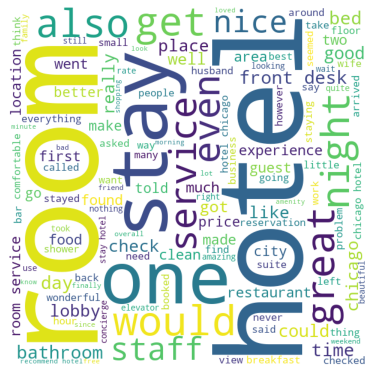

In [31]:
# visualizing the most frequent words using matplot library
comment_words = ' '
for words in df['text']: 
    comment_words = comment_words + words + ' '
    
wordcloud = WordCloud(width = 600, height = 600, 
                background_color='white' , 
                stopwords = stop_words, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)

### TRAIN - TEST SPLIT

In [32]:
df.head()

,label,text
0,1,stayed one night getaway family thursday triple aaa rate steal th floor room complete plasma tv bose stereo voss evian water gorgeous bathroom concierge helpful cannot beat location flaw breakfast pricey service slow even though two table restaurant food good worth wait would return heartbeat gem chicago
1,1,triple rate upgrade view room le also included breakfast voucher great view river lake wrigley bldg tribune bldg major restaurant shopping sightseeing attraction within walking distance large room comfortable bed
2,1,come little late finally catching review past several month dear friend stayed hyatt regency late october one night visiting friend husband town hotel perfect imo easy check check lovely clean comfortable room great view city know area pretty well convenient many downtown chicago attraction dinner went clubing friend around division st problem getting cab back forth hyatt even public transportation right near bother since needed cab hotel parking usual chicago expensive able get car quickly problem best part got rate hotwire downright steal area chicago quality hotel
3,1,omni chicago really delivers front spaciousness room helpful staff prized location michigan avenue address chicago requires high level quality omni delivers check whole group people minute staff plentiful recommendation dining event room largest find price range chicago even standard room separate living area work desk fitness center free weight weight machine two row cardio equipment shared room others feel cramped way great property
4,1,asked high floor away elevator got room pleasantly decorated functional clean need whole lot service pleasant prompt used fitness center well equipped everything working order great location one end michigan avenue shopping district


In [33]:
x = df['text']
y = df['label']

In [34]:
# train - test split equally splitting both 0 and 1.
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42, stratify = y) 

In [35]:
X_test.head()

213                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       stayed night great hotel updated room clean used tim book theater dinning reservation provided excellent service close subway shopping dinning excellent value free wireless internet access nearby health club nice perk highly recommend future concern adjacent construction condo problem something ask front desk future
228                                                                                                                                                                                             

## TEXT AUGMENTATION USING SYNONYMS:

In [36]:
aug = naw.SynonymAug(aug_src='wordnet',aug_max=5)

In [37]:
sum(y_train==0)

640

In [38]:
sum(y_train==1)

640

In [39]:
naw.SynonymAug(aug_src='wordnet',aug_max=5).augment("The staff was very polite and helpfull and the rooms were very comfortable and felt like home.",n=10)

['The staff was real civilized and helpfull and the rooms be very comfortable and felt like base.',
 'The staff was very polite and helpfull and the elbow room were very comfy and palpate like habitation.',
 'The staff live very polite and helpfull and the rooms make up very comfortable and felt similar home.',
 'The staff was very polite and helpfull and the suite were real comfortable and feel like home.',
 'The faculty was very polite and helpfull and the room were very comfortable and feel same home.',
 'The staff was very polite and helpfull and the suite be very comfortable and felt like dwelling.',
 'The staff was very civilised and helpfull and the rooms were really comfortable and feel like home.',
 'The staff be real polite and helpfull and the rooms were very comfortable and felt like household.',
 'The stave was really polite and helpfull and the rooms were very comfortable and finger like home.',
 'The staff embody very polite and helpfull and the rooms were very well situ

In [40]:
augmented_sentences=[]
augmented_sentences_labels=[]
for i in X_train.index:
  if y_train[i]==0:
    temps=aug.augment(X_train[i],n=10)
    for sent in temps:
      augmented_sentences.append(sent)
      augmented_sentences_labels.append(0)
  else :
    temps=aug.augment(X_train[i],n=10)
    for sent in temps:
      augmented_sentences.append(sent)
      augmented_sentences_labels.append(1)

In [41]:
# after augumenting, our dataset is multiplied with 10 times.
X_train=X_train.append(pd.Series(augmented_sentences),ignore_index=True)
y_train=y_train.append(pd.Series(augmented_sentences_labels),ignore_index=True)

print(X_train.shape)
print(y_train.shape)

(14080,)
(14080,)


In [42]:
X_train

0                                                                                  oh goodness got one worst place stay downtown chicago went well enough checking went downhill much left desired biggest problem huge turd toilet kid guess maid rather busy day took break forgot know price charge type thing unacceptable everything else actual room expected noise bit used though convention college age kid staying floor u asked moved another room get u another room took nearly hour second room worked well u risking staying plus pool available really wish would mentioned website looking forward day beautiful place wonderful location need work customer service reconsider staying homewood suite hilton chicago downtown
1                                                                                                                                                                                                                                                                                       

In [43]:
y_train.value_counts()

1    7040
0    7040
dtype: int64

In [44]:
# checking the count of  y_test value 
y_test.value_counts()

1    160
0    160
Name: label, dtype: int64

In [45]:
X_test.head()

213                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       stayed night great hotel updated room clean used tim book theater dinning reservation provided excellent service close subway shopping dinning excellent value free wireless internet access nearby health club nice perk highly recommend future concern adjacent construction condo problem something ask front desk future
228                                                                                                                                                                                             

In [47]:
train_df = pd.DataFrame(X_train)
train_df['target'] = y_train
train_df.head()

,0,target
0,oh goodness got one worst place stay downtown chicago went well enough checking went downhill much left desired biggest problem huge turd toilet kid guess maid rather busy day took break forgot know price charge type thing unacceptable everything else actual room expected noise bit used though convention college age kid staying floor u asked moved another room get u another room took nearly hour second room worked well u risking staying plus pool available really wish would mentioned website looking forward day beautiful place wonderful location need work customer service reconsider staying homewood suite hilton chicago downtown,0
1,stayed night last summer booked reservation priceline night cheapest rate could find anywhere convention week anyway arrived pm airport told overbooked hotel room booked dumpy star motel airport gave taxi get cost late meeting next morning extra travel packing unpacking millennium offered compensation whatsoever foul free drink room upgrade nothing since booked internet chopped liver beware,1
2,recently stayed affina chicago hotel really dissappointed arrived desk clerk really slow checking feel like turtle could checked faster finally checked room th floor elevator ride seemed take forever arrived room first glance looked great looking everything finger smudge glass table figured maybe room cleanin must accidentally touched went c house supper evening wait seemed like forever meal good waitress uptight way back room asked front desk set wake call next morning grateful set would nice actually get though next morning surprisingly work realized received wake call upset let know overall experience worth star hotel given price quality rating affina chicago hotel given would expect better service,0
3,reading good review affinia hotel chicago husband decided spend two night celebrate th anniversary unfortunately hotel missed mark u expect find bedbug underneath mattress star hotel husband bad experience bedbug rule always check underneath mattress settling night hotel brought attention front desk staff practically accused u planting bug humiliated disappointed way situation handled needle say made decision pack bag went elsewhere celebrate anniversary written letter hotel chain hope responsive situation also reported incident credit card company alert refuting charge one night affinia charged account missed cancellation deadline,0
4,stayed fitzpatrick result glowing review tripadvisor avoid normal corporate hotel good location room dirty last housekeeping dingy place needed slipper provided suite also refrigerator caked ice work furthermore travel agent mixed date travel showed day late hotel said problem charged show night travel desk verify hotel management day fitzpatrick charged night refused reverse charge many attempt resolve neither corporate travel desk use fitzpatrick two dot good location lobby clean generally easy please slow complain bad,1


In [48]:
eval_df = pd.DataFrame(X_test)
eval_df['target'] = y_test
eval_df.head()

,text,target
213,stayed night great hotel updated room clean used tim book theater dinning reservation provided excellent service close subway shopping dinning excellent value free wireless internet access nearby health club nice perk highly recommend future concern adjacent construction condo problem something ask front desk future,1
228,loved ambassador great hotel really beautiful room absolutely striking classic elegant everything done really well staff treated like regular top notch hotel best place stayed long time complaint wish mile,1
809,room booked room told getting king bed check say queen bed room available protested avail got room really full size bed went king bed home full size bed tiny broom closet room chicago pleasure paid price normal king bed room full size bed also extremely uncomfortable think lop sided never rotate mattress would wake body ache headache wife even said lost feeling arm night good also internet room hard set slow use inconsistent generally restart computer least get internet work internet worked one day iphone would log really worth room service room service inconsistent nonsensical morning would take towel replace time would replace towel others would also come vastly different time hotel service hotel love nickel dime asked fridge room told hotel ever stayed ever charged fridge room late ...,1
1522,amalfi hotel advertises luxury boutique hotel expected experience somewhat better average unfortunately case room booked clean particular bathroom looked someone done minimal amount cleaning last guest hair corner room leading think floor swept cleaned addition although room supposed non smoking room could still detect odor cigarette smoke say staff courteous hotel well situated term many restaurant site shop within walking distance however given cost room experience cleanliness room would stay amalfi hotel,0
1003,gone downhill much almost checked stayed dean martin celebrity suite night entertaining customer chicago stayed many year date like four season peninsula always comfortable clean service oriented hotel room service eliminated complimentary morning coffee longer available mini bar removed room etc etc restaurant pump room closed private function saturday night bar also even able dinner drink guest surely function planned made reservation told also learned bell staff eliminated word anyting service gone hotel hear going begin renovation december excuse let old glory go pot meantime staying go back july thanksgiving even pay internet mind bill night room service restaurant bar charge highway robbery get ow ambassador east sad,1


In [49]:
train_df.shape, eval_df.shape

((14080, 2), (320, 2))

### MODEL BUILDING -- BERT MODEL

In [50]:
# We will import ClassificationModel - as we need to solve binary text classification
from simpletransformers.classification import ClassificationModel
import logging
import sklearn


logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

In [51]:
# Create a ClassificationModel
model = ClassificationModel('distilbert', 'distilbert-base-uncased', args={'num_train_epochs':4, 'train_batch_size':32, 'max_seq_length':128}) # You can set class weights by using the optional weight argument

# Train the model
model.train_model(train_df)

# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(eval_df, acc=sklearn.metrics.accuracy_score)

INFO:filelock:Lock 139955198554640 acquired on /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333.lock


Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

INFO:filelock:Lock 139955198554640 released on /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333.lock
INFO:filelock:Lock 139955199078224 acquired on /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a.lock


Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

INFO:filelock:Lock 139955199078224 released on /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a.lock
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassificati

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

INFO:filelock:Lock 139955591128208 released on /root/.cache/huggingface/transformers/0e1bbfda7f63a99bb52e3915dcf10c3c92122b827d92eb2d34ce94ee79ba486c.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99.lock
INFO:filelock:Lock 139955199403024 acquired on /root/.cache/huggingface/transformers/75abb59d7a06f4f640158a9bfcde005264e59e8d566781ab1415b139d2e4c603.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4.lock


Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

INFO:filelock:Lock 139955199403024 released on /root/.cache/huggingface/transformers/75abb59d7a06f4f640158a9bfcde005264e59e8d566781ab1415b139d2e4c603.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4.lock
INFO:filelock:Lock 139955590070672 acquired on /root/.cache/huggingface/transformers/8c8624b8ac8aa99c60c912161f8332de003484428c47906d7ff7eb7f73eecdbb.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79.lock


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

INFO:filelock:Lock 139955590070672 released on /root/.cache/huggingface/transformers/8c8624b8ac8aa99c60c912161f8332de003484428c47906d7ff7eb7f73eecdbb.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79.lock
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/14080 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_distilbert_128_2_2


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/440 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/440 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/440 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/440 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/320 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_distilbert_128_2_2


Running Evaluation:   0%|          | 0/40 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.7193323867701732, 'tp': 126, 'tn': 148, 'fp': 12, 'fn': 34, 'auroc': 0.95740234375, 'auprc': 0.9559719692058299, 'acc': 0.85625, 'eval_loss': 1.1290608519267153}


In [61]:
result

{'acc': 0.85625,
 'auprc': 0.9559719692058299,
 'auroc': 0.95740234375,
 'eval_loss': 1.1290608519267153,
 'fn': 34,
 'fp': 12,
 'mcc': 0.7193323867701732,
 'tn': 148,
 'tp': 126}

#### Conclusion : Using bert, we achieved 86% accuracy.